# Get Results Fast with fastai

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

![](../graphics/fastai-01.png)

## 1. The fastai Philosophy

- [fastai](https://www.fast.ai/) is a software package and course created by Jeremy Howard, Rachel Thomas, and Sylvain Gugger. 
- A good way to think about fastai is as a high level PyTorch wrapper library. If you're familiar with keras, **tensorflow is to keras and pytorch is (roughly) to fastai.**
- Unlike keras, fastai is **very opinionated** library. 
- Instead of creating a generic tools for deep learning experts to use, the fastai founders are creating courses and a library that make it **dramatically easier and faster** to get cutting-edge results quickly with deep learning. 
- One tool they use to accomplish this is by **encoding best practices from research directly into the library**. 
- This approach has led to some pretty dramatic results, including [training a model on imagenet in 18 minutes](https://www.fast.ai/2018/08/10/fastai-diu-imagenet/) and some breakthrough results in [pretraining models for natural language processing](https://arxiv.org/pdf/1801.06146.pdf). 
- Now, there are some trade-offs. In my experience, fastai can be buggy, difficult to debug, and challenging to generalize in some cases. 
- My thinking on these trade-offs, in late 2019, is this: 


1. For quickly exploring + testing top-performing models and new ideas on your own datasets, **it's hard to beat fastai**. In my experience, you'll be able to test lots of ideas quickly, and move fast. 
2. Having a reasonable good understanding of the underlying PyTorch code can make you much more effective with fastai, allowing you to "pick and choose" the parts of the fastai library you want to use, and what you want to implement yourself in PyTorch. 
3. I still really like Keras and Tensorflow, but I rarely use these libraries as **starting points** on new projects. 

---

## 2. Image Classification with fastai

- Let's train an image classifier with fastai!
- We'll go after **one of the first problems in comptuer vision**, the MIT summer vision project. 
- If you've spent any time with thhis [original computer vision problem](https://github.com/unccv/the_original_problem), then you konw that's it's alot more difficult than it appears!

![](../graphics/summer_project_goals-01.png)


- To use a deep learning approach, we'll need some data!
- We'll use what we're calling the **BBC-1k** dataset - 1000 images of bricks, balls, and cylinders!
- You can download the dataset [here](http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip) - please unzip and place in the /data directory of this repo (gitigonored).
- Alternatively you can download with our helper tool: 

```
python util/get_and_unpack.py -url http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip
mv bbc_train data
```

![](../graphics/bbc1k.gif)

### Optional in Lecture - let's code this part from scratch in an empty notebook.

In [2]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
path=Path('../data/bbc_train')

In [4]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/masks')]

- The BBC-1k dataset inlcudes labels for classification, bounding box detection, and semantic segmentation. 
- Let's load the classification labels:

In [5]:
labels=pd.read_csv(path/'classification_labels.csv')

In [6]:
labels.head()

,filename,label,label_index
0,P2050936.jpg,ball,2
1,P2050922.jpg,ball,2
2,P2060163.jpg,brick,1
3,P2060003.jpg,ball,2
4,P2060017.jpg,ball,2


- fastai provides lots of methods for creating data iterators, called `DataBunches` in the fastai nomenclature
- `DataBunches` allow us to quickly create pipelines for loading data into randomized minibatches

In [7]:
data=ImageDataBunch.from_df(path=path/'images', df=labels, valid_pct=0.2, fn_col='filename', label_col='label', 
                            ds_tfms=get_transforms(), size=256, bs=64).normalize(imagenet_stats)

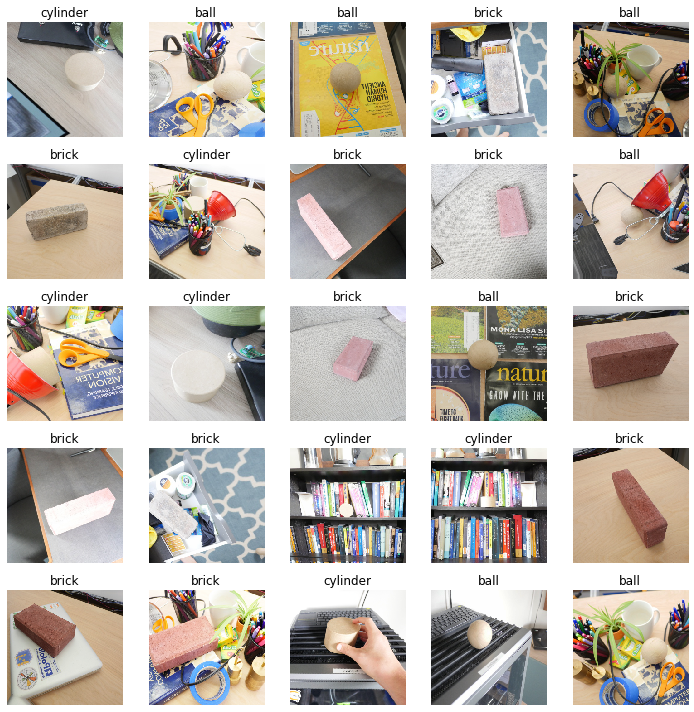

In [8]:
data.show_batch(figsize=(10,10))

- Creating a model is as simple as picking an architecture, passing in our `ImageDataBunch`, and choosing a performance metric!

In [9]:
learn=cnn_learner(data, models.resnet34, metrics=accuracy)

- By defualt, fastai downloads the weights for a pretrained model. 
- Usually when solving new problems, it's best to start with a pretrained model, and just train the last few layers on the new task. 
- We can do this by freezing the "model backbone": 

In [10]:
learn.freeze()

- Choosing a learning rate can be difficult. 
- fastai provides a great tool for selecting an effective learning rate, `learn.lr_find()`.
- `lr_find` takes steps using various learning rates, and measure the change in our loss function. 
- By plotting the loss as a function of learning rate, we can select an ideal learning rate. 
- Ideally, we want to pick a learning that maximizes the slope of our loss vs learning rate curve. 

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

- Fastai has a couple of other terrific built in features, **cylical learning rates**, and **differential learning rates**. 
- We're using each of these here, and will cover them in more detail later. 

In [ ]:
lr=5e-3
learn.fit_one_cycle(4, slice(lr/10, lr))

- We can further improve performance by training the whole model, not just our last few layers. 

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr=5e-5
learn.fit_one_cycle(8, slice(lr/10, lr))

- fastai also has some really nice visualization & interpretation methonds

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
interp.plot_top_losses(k=6, figsize=(12, 8))

## 3. Object Detection with fastai

- Let's see what else we can do with fastai!
- Thanks to some hard work from our terrific TAs, we also have bounding box annotations for each image in our dataset. 
- Let's see if we can train a deep learning model to detect bounding boxes around our bricks, balls, cylinders!
- **What modifications to our neural network do we need to make to our network to allow it make this kinda of prediction?**
- What really remarkable (as you'll see) is how little we really need to change to perform this task well. 

In [1]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


### 3.1 Data 

In [2]:
path=Path('../data/bbc_train')

In [3]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/models'),
 PosixPath('../data/bbc_train/masks')]

In [4]:
labels=json.load(open(path/'bboxes.json', 'r'))

In [5]:
labels.keys()

dict_keys(['images', 'annotations', 'type', 'categories'])

In [6]:
labels['annotations'][12]['bbox']

[282.39102564102564, 174.0, 70.19230769230762, 67.62820512820511]

- Instead of writing our own json importer, we'll us a fastai method for this:

In [7]:
images, lbl_bbox = get_annotations(path/'bboxes.json')

In [8]:
len(images), len(lbl_bbox)

(1185, 1185)

In [9]:
images[:5]

['P2050936.jpg',
 'P2050922.jpg',
 'P2060163.jpg',
 'P2060003.jpg',
 'P2060017.jpg']

In [10]:
lbl_bbox[0]

[[[145.47435897435898,
   254.82692307692304,
   237.14102564102564,
   347.4551282051282]],
 ['ball']]

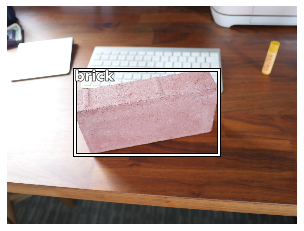

In [11]:
i=2
img = open_image(path/'images'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

- Let's setup our fastai data loading pipeline:

In [12]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [13]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'images')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [14]:
data = get_data(bs=64,size=256)

In [15]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Valid: LabelList (188 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Test: None

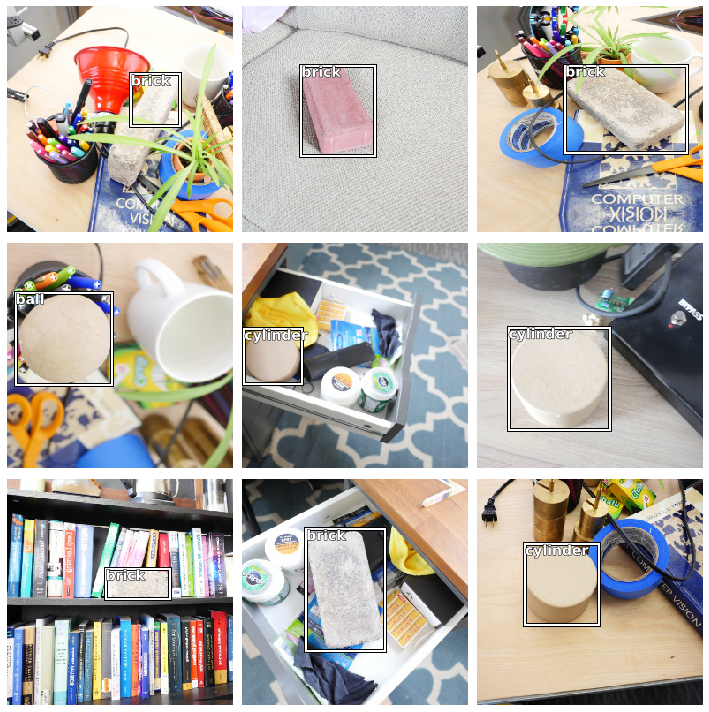

In [16]:
data.show_batch(rows=3, figsize=(10,10))

### 3.2 Model

- Now that our dataloading pipeline is setup, let's think about what changes we need to make to our network. 
- A nice feature of fastai is the ability to easilty attach a "custom head" to a pretrained "backbone". 
- Let's start thinking about the type of output we for our object detection network. 
- Is this a Regression or Classification Problem?
- What is the Dimenion of the output we need from our neural network?

---

- We'll create our own custom head and loss function here
- Don't worry about the exact implementation details here too much just yet - mostly pay attention to the dimensions of the inputs and outputs!
- `AdaptiveConcatPool2d` is a really nice layer that allows us to handle input images of different sizes. 

In [18]:
custom_head = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))

In [19]:
class MyLoss(nn.Module):
    def forward(self, output, bbox_tgts, class_tgts):
        return nn.L1Loss()(output.unsqueeze_(dim=1), bbox_tgts)

In [20]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss())

In [21]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [22]:
learn.freeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


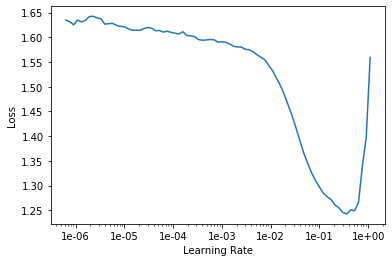

In [23]:
learn.recorder.plot()

In [23]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,1.479751,2.454315,00:14
1,1.093341,0.687126,00:10
2,0.818618,0.219280,00:10
3,0.651001,0.178319,00:10


In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


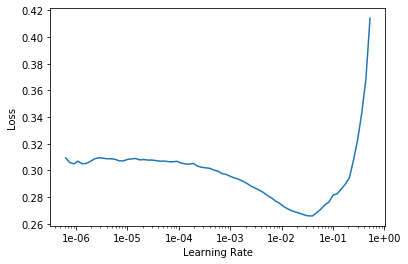

In [26]:
learn.recorder.plot()

In [27]:
lr=1e-3
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,0.299297,0.141131,00:12
1,0.280001,0.144816,00:12
2,0.252484,0.120701,00:12
3,0.227542,0.083917,00:12
4,0.210553,0.086331,00:12
5,0.195771,0.076222,00:12
6,0.183679,0.063846,00:12
7,0.172250,0.061483,00:12


In [28]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,0.137648,0.057897,00:12
1,0.137136,0.061559,00:12
2,0.136924,0.055166,00:12
3,0.132451,0.050861,00:12
4,0.130441,0.058561,00:12
5,0.126298,0.048526,00:12
6,0.122206,0.045009,00:12
7,0.119768,0.044544,00:12


In [30]:
learn.save('object-detector-1')

### 3.3 Visualize Results

In [35]:
def compute_corner_locations(y, im_shape=(256,256)):
    shape_vec=np.array(im_shape*2)
    bounds=((y+1)*shape_vec/2).ravel()
    corners=np.array([[bounds[1], bounds[0]], 
                      [bounds[3], bounds[0]],
                      [bounds[3], bounds[2]],
                      [bounds[1], bounds[2]],
                      [bounds[1], bounds[0]]])
    return corners

In [36]:
x,y = next(iter(learn.data.valid_dl))
with torch.no_grad():
    yhat = learn.model(x.to('cuda'))

In [37]:
x.shape, y[0].shape, yhat.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 1, 4]), torch.Size([64, 4]))

In [38]:
#Reshape image block and convert to numpy for visualization: 
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

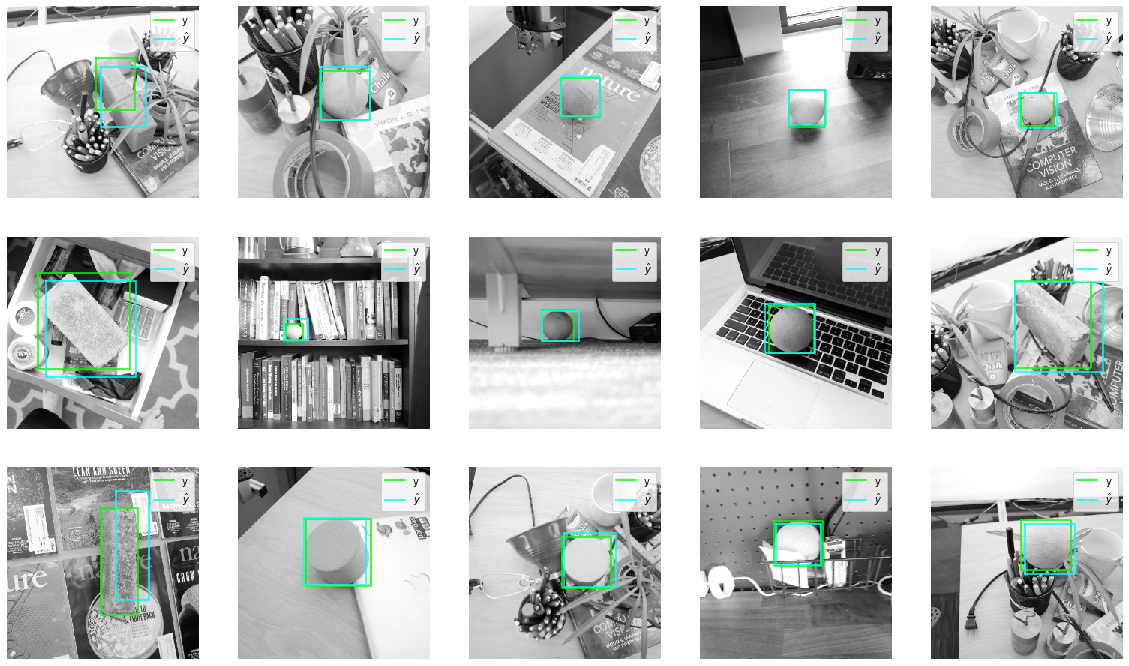

In [41]:
fig=figure(0, (20,12))
for i in range(15): 
    fig.add_subplot(3,5,i+1)
    imshow(x_numpy[i].mean(axis=2), cmap='gray')
    
    corners=compute_corner_locations(y[0][i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 0))
    
    corners=compute_corner_locations(yhat[i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 1))
    axis('off')
    legend(['y', '$\hat{y}$'])

- Not bad, right!?
- Now, there's a lot more to object detection - there's lots of ways to further improve on the performance we're achieving here. More importantly, we haven't solved object detection in the general case. **Why not?**
- This issue here is that we have no way for our algorithm to detect multple objects in the same image!
- There's alot that goes into handling multiple objects in the same image - the [SSD](https://arxiv.org/pdf/1512.02325.pdf), [Yolo](https://arxiv.org/pdf/1506.02640.pdf), and [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) papers are a great place to start learning about more sophisticated appraoches. 

## 4. Semantic Segmentation with fastai

- But wait, there's more! 
- Let's explore one more type of problem we can solve using a very similar architecture: **semantic segmentation**. 

## 5. Multitask Learning with fastai